In [19]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import cPickle as pickle 
from time import time

В TfidfVectorizer не зашита лемматизация, вопользуемся инструментом из nltk, переопределим лемматизатор и используем его при преобразовании в вектор.

In [13]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Используем только тренировочную часть датасета, чтобы не тратить много времени, так как железо у нас и так не очень мощное.

In [14]:
ds = fetch_20newsgroups(subset = "train")

Также отфильтруем стоп-слова из словаря (словарь найден на просторах интернета).

In [15]:
stop_words = open('/home/jule/Downloads/stopwords_en.txt', 'r').readlines()

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, stop_words=stop_words, tokenizer=LemmaTokenizer())

Векторизуем данные и оценим масштаб трагедии в секундах.

In [17]:
t_start = time()
tfidf = tfidf_vectorizer.fit_transform(ds.data)
print("done in %0.3fs." % (time() - t_start))

done in 2078.060s.


Чтобы не возвращаться более к этому этапу, сохраним полученные данные (разреженную матрицу).

In [18]:
with open('tfidf.dat', 'wb') as outfile:
    pickle.dump(tfidf, outfile, pickle.HIGHEST_PROTOCOL)

Этап 1 завершен.

In [20]:
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
with open('tfidf.dat', 'rb') as infile:
    vectorized_data = pickle.load(infile)

K-means с количеством кластеров равным исходному.

In [30]:
num_clusters = 20

km = KMeans(n_clusters=num_clusters, max_iter = 1000, n_jobs = 4)

%time km.fit(vectorized_data)

clusters = km.labels_.tolist()

CPU times: user 3.3 s, sys: 3.61 s, total: 6.92 s
Wall time: 5min 15s


In [31]:
joblib.dump(km,  'doc_cluster.pkl')

['doc_cluster.pkl', 'doc_cluster.pkl_01.npy', 'doc_cluster.pkl_02.npy']

In [32]:
model = joblib.load('doc_cluster.pkl')
clusters = model.labels_.tolist()

Преобразуем данные (сократим размерность) для того, чтобы их можно было изобразить на двумерном графике. Статьи на http://scikit-learn.org для работы с разреженными матрицами предлагают использовать TruncatedSVD. Его и возьмем.

In [46]:
svd = TruncatedSVD()
new_data = svd.fit_transform(vectorized_data) 

In [53]:
from sklearn import metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ds.target, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(ds.target, model.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(ds.target, model.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(ds.target, model.labels_))

Homogeneity: 0.150
Completeness: 0.176
V-measure: 0.162
Adjusted Rand-Index: 0.050


И наконец-то отобразим данные.

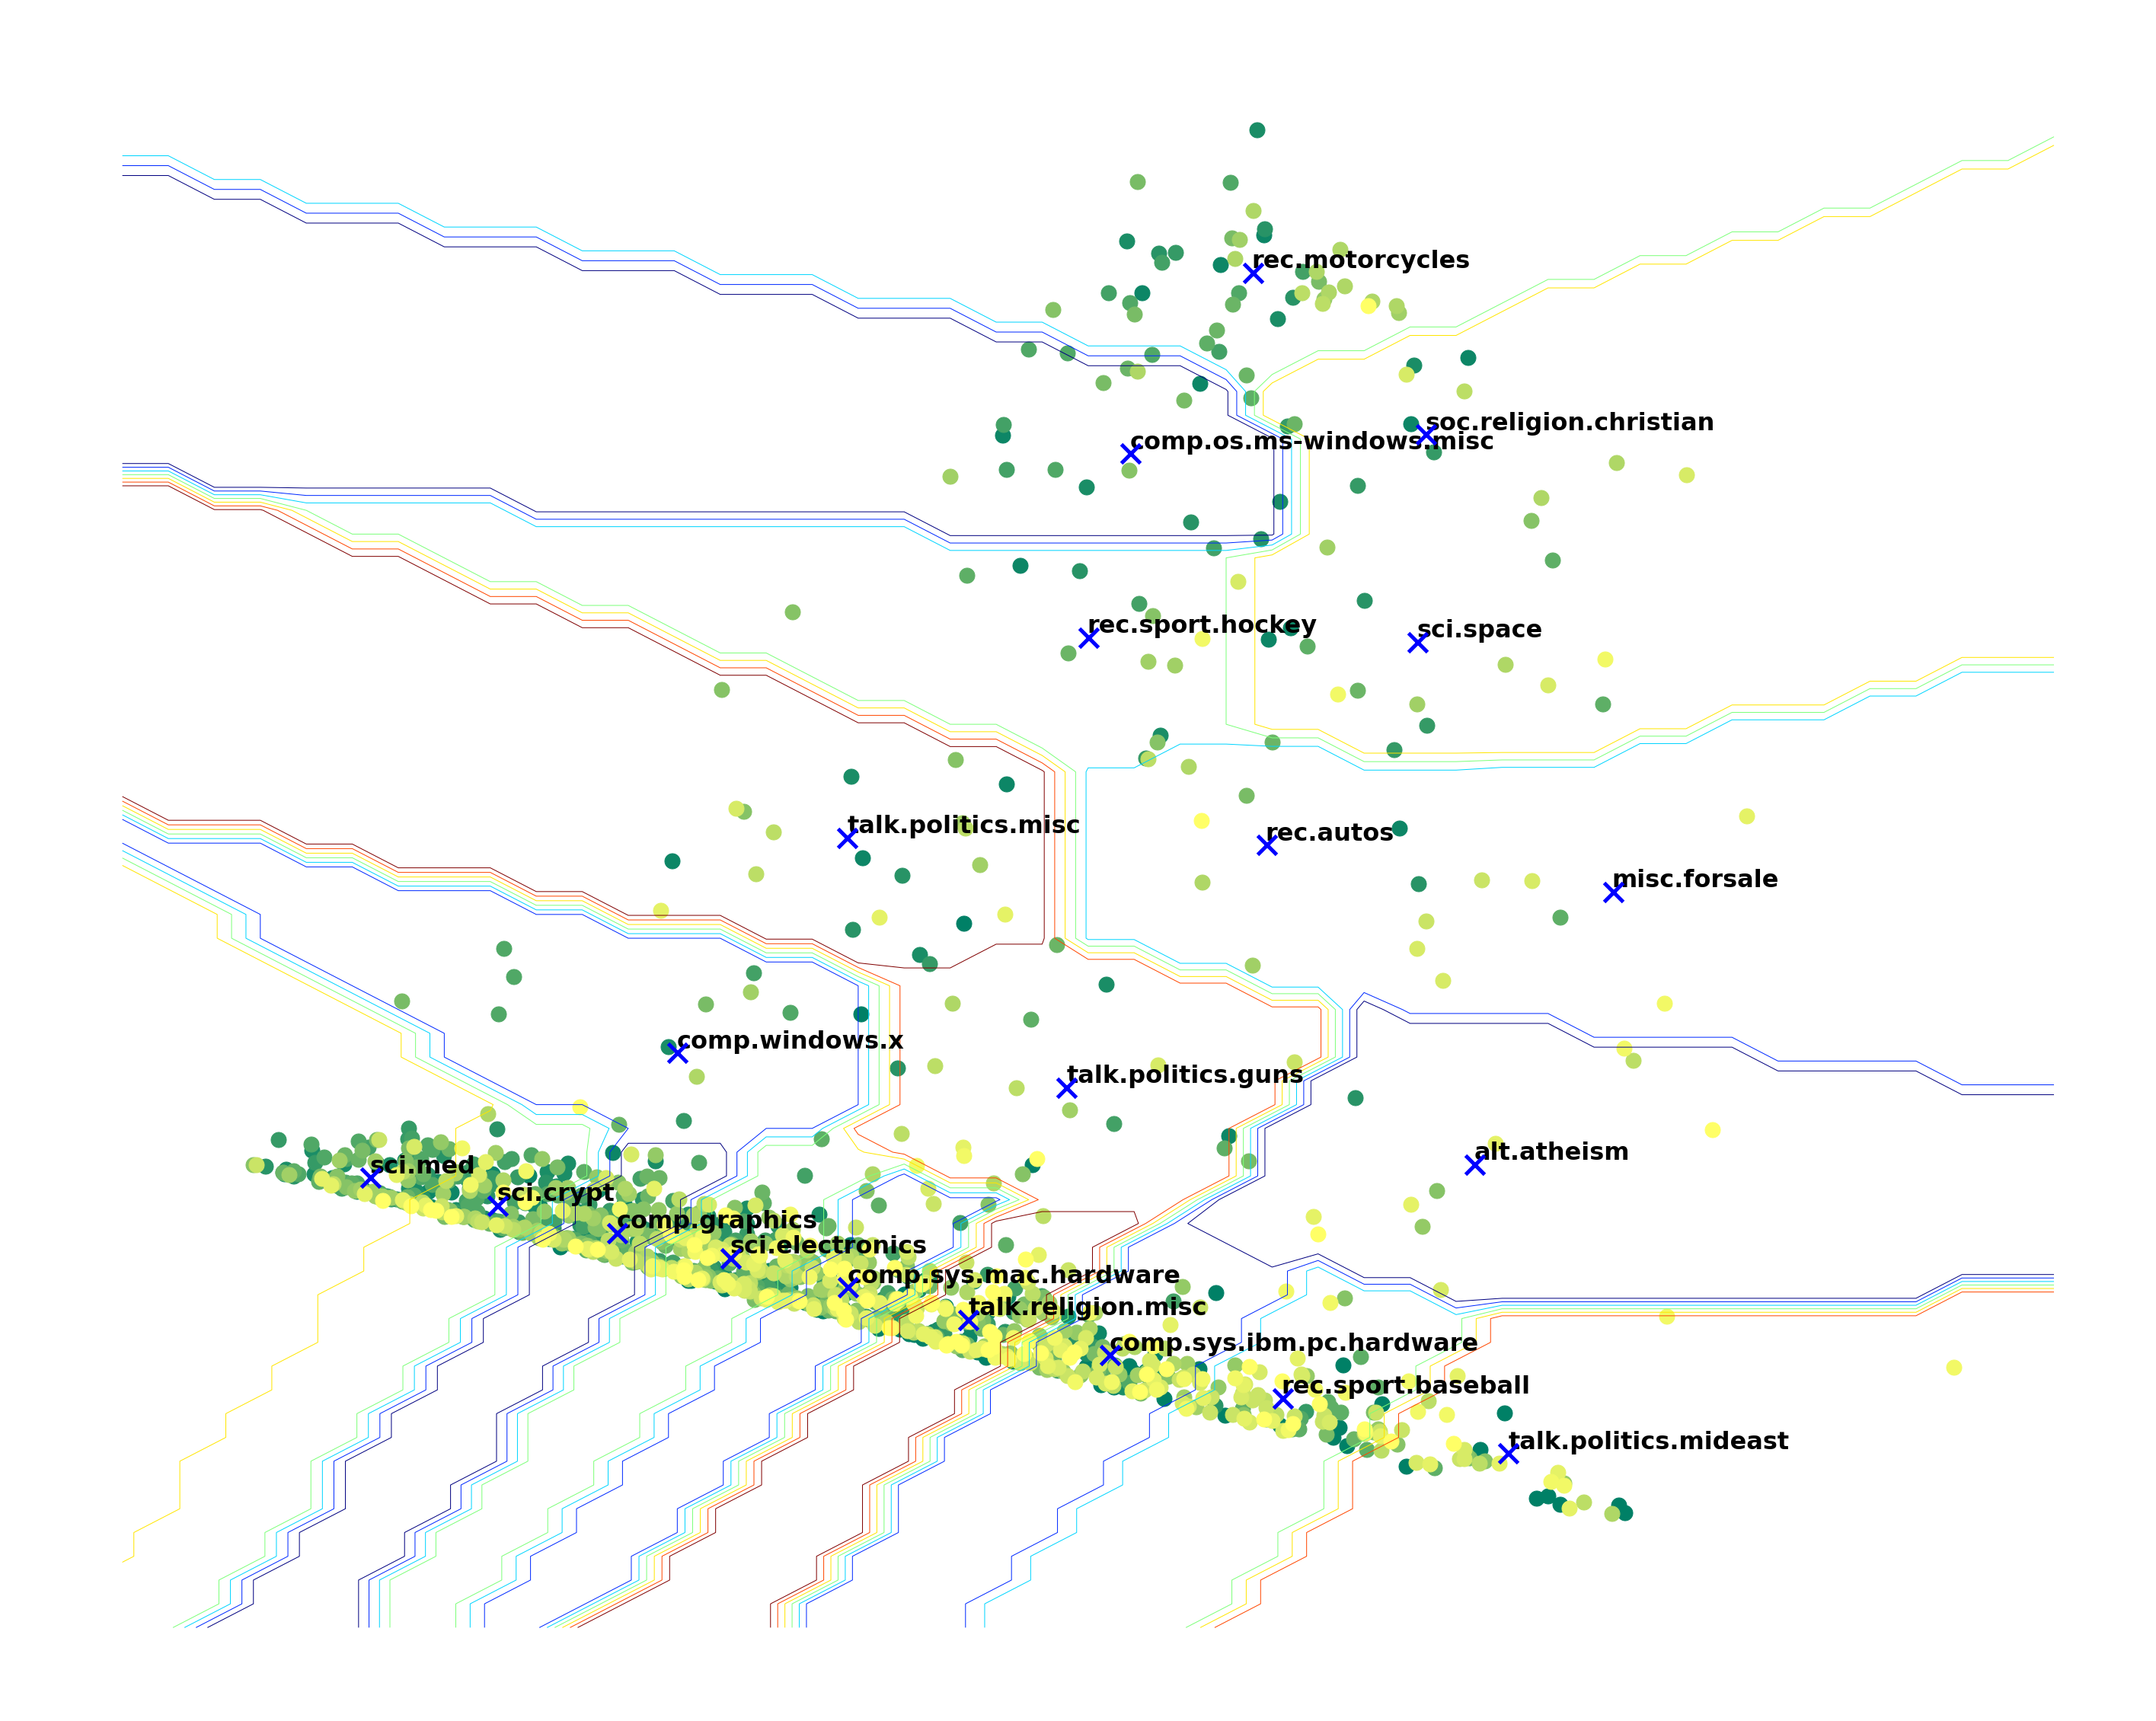

In [75]:
import matplotlib.cm as cm

x_min, x_max = new_data[:, 0].min() - 0.05, new_data[:, 0].max() + 0.05
y_min, y_max = new_data[:, 1].min() - 0.05, new_data[:, 1].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

model.fit(new_data)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
class_labels = set(model.labels_)
y_names = ds.target_names


plt.figure(figsize=[50, 40])
plt.clf()
plt.contour(xx, yy, Z)
plt.axis('off')

centroids = model.cluster_centers_    

for n,c in zip(y_names, centroids):
    plt.text(c[0], c[1], n,fontsize=32,fontweight='bold', ha='left',va='bottom',color='k')

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=625, linewidths=5,
            color='b', zorder=10)
    
colors = np.linspace(0, 1, len(class_labels))
c_map = plt.get_cmap("summer")

for l, c in zip(class_labels, c_map(colors)):
    l_class = np.where(ds.target == l)[0]
    l_class = l_class[:70]
    plt.scatter(new_data[l_class, 0], new_data[l_class, 1], color=c, s=400)
plt.show()  